In [14]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# **Espectro de luz de una imagen:**

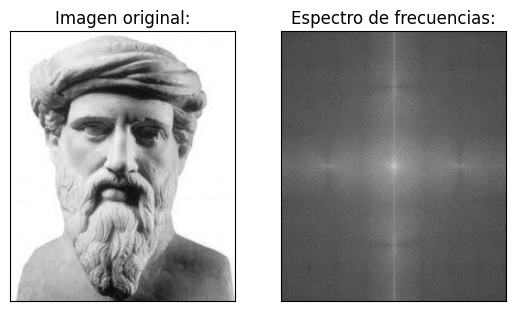

In [15]:
img = cv2.imread('/content/R.jpg', 0)
f = np.fft.fft2(img)
fshift = np.fft.fftshift(f)
magnitude_spectrum = 20 * np.log(np.abs(fshift))
plt.subplot(121), plt.imshow(img, cmap='gray')
plt.title('Imagen original:'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('Espectro de frecuencias:'), plt.xticks([]), plt.yticks([])
plt.show()

In [16]:
magnitude_spectrum_normalized = cv2.normalize(magnitude_spectrum, None, 0, 255, cv2.NORM_MINMAX)
magnitude_spectrum_uint8 = np.uint8(magnitude_spectrum_normalized)
output_path = '/content/magnitude_spectrum.png'
cv2.imwrite(output_path, magnitude_spectrum_uint8)

print(f"El espectro de magnitud se ha guardado como: {output_path}")

El espectro de magnitud se ha guardado como: /content/magnitude_spectrum.png


# **Descomposición de una imagen en sus frecuencias:**

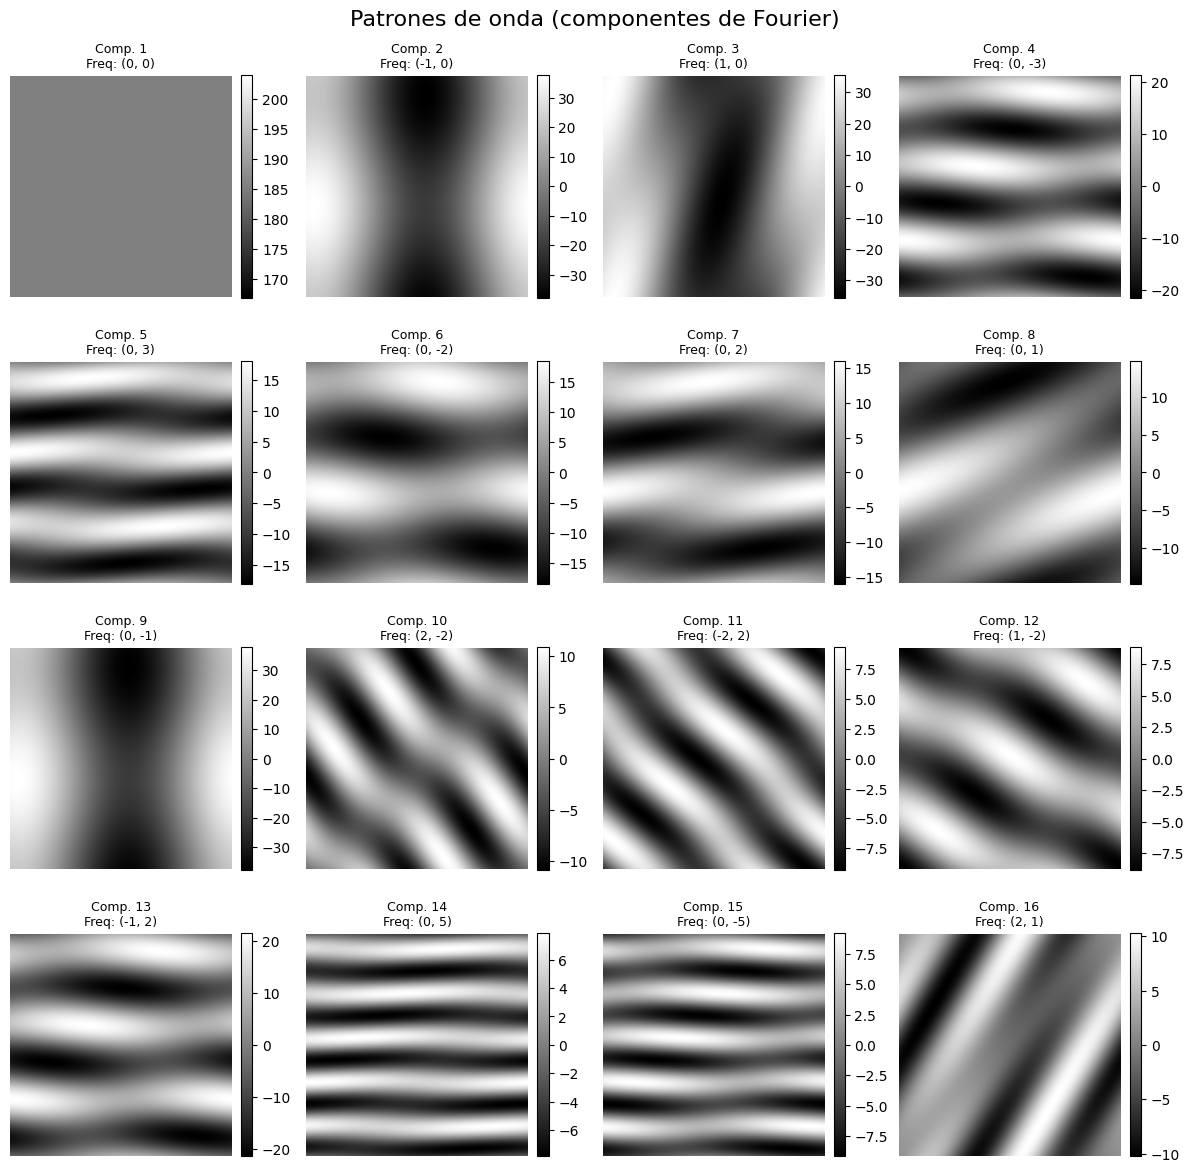

In [17]:
from PIL import Image

# Cargar imagen en escala de grises
def load_image(path, size=(256, 256)):
    img = Image.open(path).convert('L')
    img = img.resize(size)  # Redimensionar para velocidad y visualización
    return np.array(img)

# Ruta de imagen
image_path = '/content/R.jpg'

# Cargar y preparar
img = load_image(image_path)
rows, cols = img.shape

# 1. Calcular FFT 2D
f = np.fft.fft2(img)
fshift = np.fft.fftshift(f)  # Centrar frecuencias

# 2. Obtener magnitudes y ordenar por importancia
magnitudes = np.abs(fshift)
indices = np.unravel_index(np.argsort(-magnitudes.flatten()), magnitudes.shape)

# 3. Seleccionar los N componentes más fuertes (patrones más importantes)
N = 16  # Número de patrones a mostrar (4x4 cuadrícula)
top_indices = list(zip(indices[0][:N], indices[1][:N]))

# 4. Crear figura para mostrar patrones
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
axes = axes.flatten()

for i, (r, c) in enumerate(top_indices):
    pattern = np.zeros_like(fshift, dtype=complex)
    pattern[r, c] = fshift[r, c]
    if r != rows//2 or c != cols//2:
        pattern[rows-1-r, cols-1-c] = fshift[rows-1-r, cols-1-c]

    # Transformada inversa para obtener el patrón espacial (onda)
    wave = np.fft.ifft2(np.fft.ifftshift(pattern))
    wave_real = np.real(wave)

    im = axes[i].imshow(wave_real, cmap='gray')
    axes[i].set_title(f'Comp. {i+1}\nFreq: ({c-cols//2}, {r-rows//2})', fontsize=9)
    axes[i].axis('off')
    plt.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)

plt.suptitle('Patrones de onda (componentes de Fourier)', fontsize=16)
plt.tight_layout()
plt.show()

# **Tipos de filtro con FFT:**

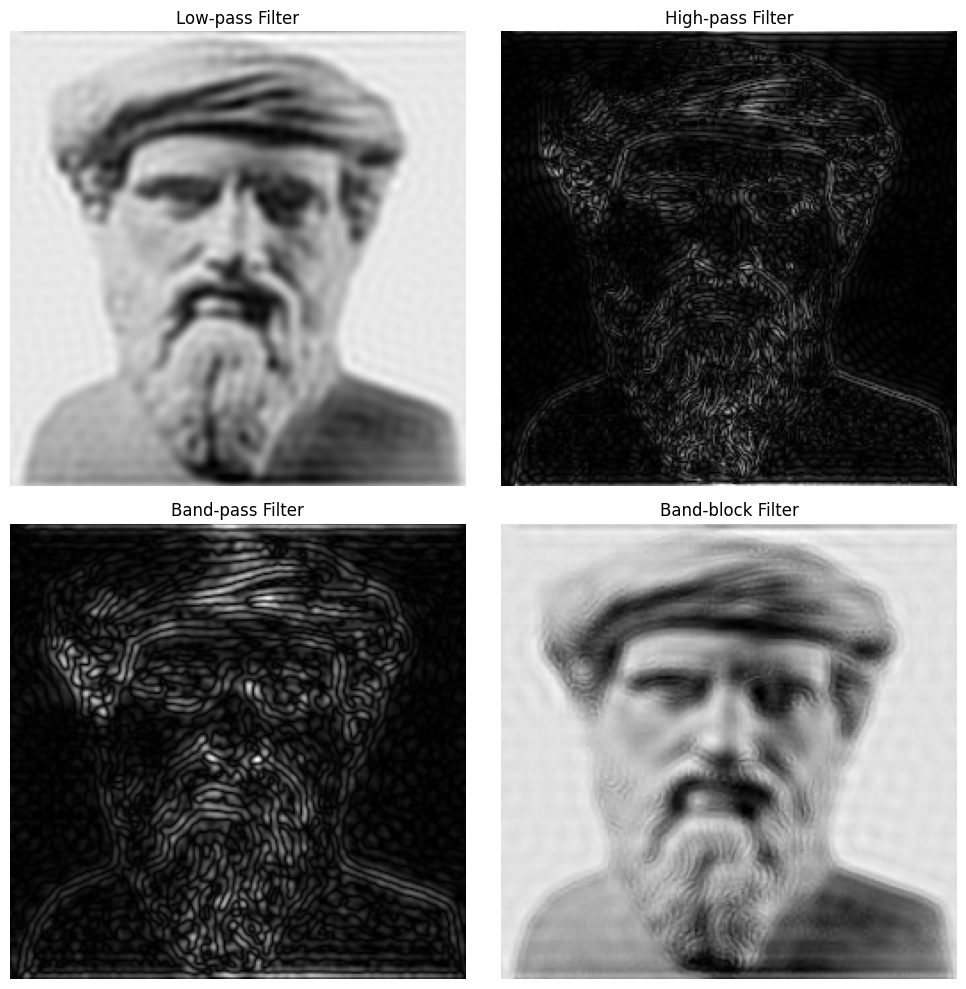

In [18]:
def create_filter_mask(shape, filter_type, radius):
    rows, cols = shape
    center_row, center_col = rows // 2, cols // 2
    mask = np.zeros((rows, cols), dtype=np.uint8)

    for i in range(rows):
        for j in range(cols):
            distance = np.sqrt((i - center_row)**2 + (j - center_col)**2)
            if filter_type == 'lowpass':
                if distance <= radius:
                    mask[i, j] = 1
            elif filter_type == 'highpass':
                if distance > radius:
                    mask[i, j] = 1
            elif filter_type == 'bandpass':
                inner_radius, outer_radius = radius
                if inner_radius < distance <= outer_radius:
                    mask[i, j] = 1
            elif filter_type == 'bandblock':
                inner_radius, outer_radius = radius
                if not (inner_radius < distance <= outer_radius):
                    mask[i, j] = 1
    return mask

# Filtros
filters = {
    'lowpass': 30,
    'highpass': 30,
    'bandpass': (20, 50),
    'bandblock': (20, 50)
}

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()
titles = ['Low-pass Filter', 'High-pass Filter', 'Band-pass Filter', 'Band-block Filter']

# Low-pass filter: Permite pasar frecuencias bajas, bloqueando las altas
# High-pass filter: Permite pasar frecuencias altas, bloqueando las bajas
# Band-pass filter: Permite que solo un determinado rango de frecuencias pase
# Band-block filter: Bloquea o remueve un determinado rango de frecuencias

for i, (filter_name, radius) in enumerate(filters.items()):
    mask = create_filter_mask(img.shape, filter_name, radius)
    fshift_filtered = fshift * mask
    f_filtered = np.fft.ifftshift(fshift_filtered)
    img_filtered = np.fft.ifft2(f_filtered)
    img_filtered = np.abs(img_filtered)

    axes[i].imshow(img_filtered, cmap='gray')
    axes[i].set_title(titles[i])
    axes[i].axis('off')

plt.tight_layout()
plt.show()

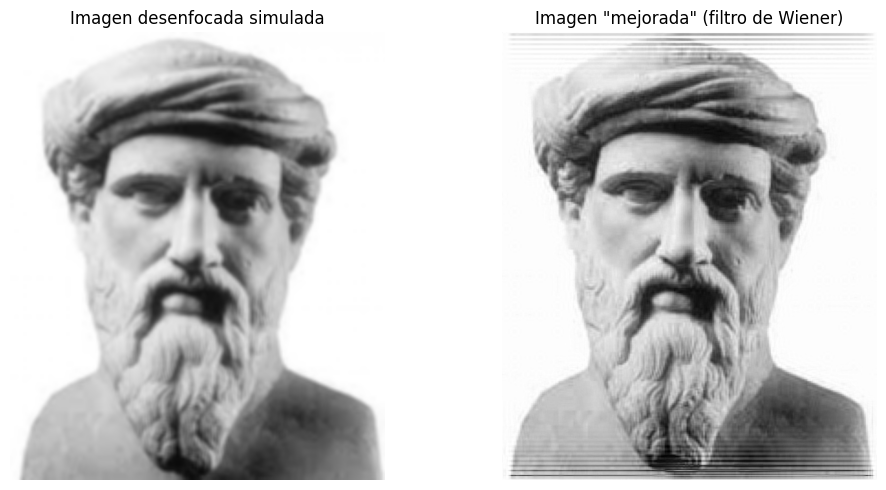

In [19]:
# Función para deblurring usando filtro de Wiener
def wiener_deblurring(img, kernel, K=0.01):
    img = np.float32(img) / 255.0
    height, width, channels = img.shape
    deblurred_img = np.zeros_like(img)
    for c in range(channels):
        img_c = img[:, :, c]
        img_fft = np.fft.fft2(img_c)
        kernel_fft = np.fft.fft2(kernel, s=(height, width))
        kernel_fft_conj = np.conj(kernel_fft)
        wiener_filter = kernel_fft_conj / (np.abs(kernel_fft)**2 + K)
        deblurred_fft = img_fft * wiener_filter
        deblurred_c = np.fft.ifft2(deblurred_fft)
        deblurred_img[:, :, c] = np.abs(deblurred_c)
    deblurred_img = np.clip(deblurred_img * 255.0, 0, 255).astype(np.uint8)
    return deblurred_img

# Cargar imagen a color
image_path = '/content/R.jpg'
img_color = cv2.imread(image_path)
img_color_rgb = cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB)

# Simular un desenfoque (kernel de ejemplo)
kernel_size = 9
kernel = np.ones((kernel_size, kernel_size), dtype=np.float32) / (kernel_size**2)
img_blurred = cv2.filter2D(img_color, -1, kernel)
img_blurred_rgb = cv2.cvtColor(img_blurred, cv2.COLOR_BGR2RGB)

# Aplicar deblurring (K)
deblurred_img = wiener_deblurring(img_blurred, kernel, K=0.005)
deblurred_img_rgb = cv2.cvtColor(deblurred_img, cv2.COLOR_BGR2RGB)

# Mostrar resultados
plt.figure(figsize=(15, 5))

#plt.subplot(1, 3, 1)
#plt.imshow(img_color_rgb)
#plt.title('Imagen Original')
#plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(img_blurred_rgb)
plt.title('Imagen desenfocada simulada')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(deblurred_img_rgb)
plt.title('Imagen "mejorada" (filtro de Wiener)')
plt.axis('off')

plt.tight_layout()
plt.show()